# PREPOZNAVANJE AUTOMOBILA

Ucitavanje biblioteka.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 
import os
from skimage.feature import hog

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn import metrics

Ucitavanje skupa podataka. Imamo dva fajla - jedan u kom se ne nalaze automobili, dok se u drugom nalaze.

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            images.append(img)
    return images

cars_far = load_images_from_folder('data\car\GTI_Far')
cars_left = load_images_from_folder('data\car\GTI_Left') 
cars_middle = load_images_from_folder('data\car\GTI_MiddleClose') 
cars_right = load_images_from_folder('data\car\GTI_Right') 
cars_kitti = load_images_from_folder('data\car\KITTI_extracted')
cars = cars_far + cars_left + cars_middle + cars_right + cars_kitti
no_cars = load_images_from_folder('data\\no car')

In [4]:
len(cars)

8786

In [5]:
len(no_cars)

7991

Pikazacemo jednu sliku automobila. Primecujemo da slika ima tri kanala jer se radio o RGB slici. 

(64, 64, 3)


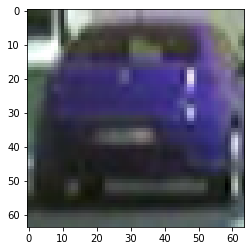

In [6]:
image = cars[267]
print(image.shape)

plt.imshow(image)
plt.show()

Prebacujemo sliku u monohromatsku.

(64, 64)


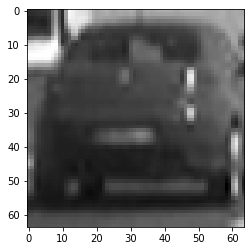

In [7]:
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image_gray.shape)

plt.imshow(image_gray, cmap = 'gray')
plt.show()